# LSDB Prototype Example Usage

Here we will provide example usage for using LSDB in analyzing sample astronomical datasets. We provide examples to:
* Import two existing source catalogs (our example is overlapping GAIA dr3 datasets) into the HiPSCat format (provided download link)
* Analyzing your imported catalog:
    * plotting your sources
    * plotting your partitioned structure
    * catalog information (columns, length, etc)
    * creating new columns
    * querying your dataset
* Spatial analysis
    * Performing conesearches
    * Comparing two catalogs (cross matching (nearest neighbors))
        * these functions return dask.dataframes, which you can in return perform follow-up analysis/computation in parallel
        



## 1.) Importing an existing source new catalog into the HiPSCat format

Here we will give a detailed overview for how to import an existing source catalog with the prototype. The partitioner is called by envoking `catalog.hips_import()`. 
* The method expects a list of catalog files to exist at the specified `file_source` parameter. 
    * These files can come from a local directory or, can be downloaded from an http server.
    * Currently accepted formats are: `csv, csv.gz, parquet` and `fits` tables (not direct images).
* The partitioner expects the following columns be specified:
    * RA and DEC (decimal format), and unique ID
    * via: `ra_kw, dec_kw` and `id_kw`
* You must specify a location at which to store your partitioned catalog 
    * via `location=/path/to/hipscat`. 
    * it defaults to current working directory.
* You can vary the threshold at which it partitions the source catalog.
    * this `threshold` keyword controls the maximum number of sources that can be contained in a single pixel, i.e. the size of the partitioned files.
* Since the partitioner runs off of the `dask.distributed` framework, it expects a `client` keyword to be passed in
* When the partitioner runs, it creates two subdirectories, `cache` and `output` in this `location`.
    * `cache` stores the downloaded source files and saves them in case it needs to be re-ran for faster processing. Can be deleted once partitioning is completed
    * `output` stores the partitioned catalog, along with the source count map, and the hipscat metadata file.

Here is an example for importing the entire gaia catalog

```python
import numpy as np
import hipscat as hc
from dask.distributed import Client

#specify the dask distributed client
client = Client(n_workers=12, threads_per_worker=1)

#specify the location of the catalog you wish to partition
# and grab the urls
file_source='http://cdn.gea.esac.esa.int/Gaia/gdr3/gaia_source/'
fmt = 'csv.gz' # can be csv, csv.gz, parquet, or fits 
urls = hc.util.get_cat_urls(url=file_source, fmt=fmt)

#some parquet dtypes aren't always interpreted correctly
# if you want to specify specific dtypes, you can do it with this dictionary
manual_dtype = {'libname_gspphot':'unicode'}

#instantiate the lsd2 partitioner object
partitioner = hc.Partitioner(
    catname='gaia', 
    fmt=fmt, 
    urls=urls, 
    id_kw='source_id',
    ra_kw='ra',
    dec_kw='dec',
    threshold=1_000_000,
    skiprows=np.arange(0,1000), # skips the first 1000 rows of gaia dr3 column metadata
    dtypes=manual_dtype
)

partitioner.run(client=client)
```

But we have written a method to download sample gaia data that we will use for the purpose of this demo. It grabs the first 10 (`[0:10]`) files from the `file_source=http://cdn.gea.esac.esa.int/Gaia/gdr3/gaia_source/` and partitions it for example catalog A: (`gaia_exA`). The it does the same thing for files `[5:15]` for catalog B: (`gaia_exB`). This ensures that there will be some overlap in the two catalogs so that we can perform cross-catalog spatial analysis (cross-matching)

In [1]:
import sys
import os
import numpy as np
from dask.distributed import Client
sys.path.insert(0, '../')
import hipscat as hc

#This should be changed to a directory dask can write its scratch directories too
DASK_CLIENT_DIR=os.getcwd()
HIPS_DIR = os.path.join(os.getcwd(), 'hipscat_dir')

In [2]:
#Imports sample hipscat data from gaia dr3 source catalog
# creates 2 hipscat catalogs: gaia_exA and gaia_exB
#  -> gaia_exA is the first 10 (0-10) files from the catalog
#  -> gaia_exB is the skip 5 and take 10 (5-15) files from the catalog. 
# we ensure they will overlap for cross-match spatial analysis.

# The hipscat will be partitioned and stored in the current working directory
# we call the partitioner directly from the hipscat (hc.Partitioner) module
# this function should take ~ 4 minutes with a dask client of 4 workers.
def import_sample_data1(location=os.getcwd(), client=None):
    
    manual_dtype = {'libname_gspphot':'unicode'}

    gaia_id_kw = 'source_id'
    gaia_ra_kw = 'ra'
    gaia_dec_kw = 'dec'
    file_source = 'http://cdn.gea.esac.esa.int/Gaia/gdr3/gaia_source/'
    sample_threshold = 500_000
    fmt = 'csv.gz'
    skiprows = np.arange(0,1000)

    urls1 = hc.util.get_cat_urls(url=file_source, fmt=fmt)[0:10]
    partitioner1 = hc.Partitioner(catname='gaia_exA', fmt=fmt, urls=urls1, id_kw=gaia_id_kw,
                    order_k=10, dtypes=manual_dtype, verbose=True, debug=False, ra_kw=gaia_ra_kw, dec_kw=gaia_dec_kw,
                    threshold=sample_threshold, location=location, skiprows=skiprows)
    partitioner1.run(client=client)


def import_sample_data2(location=os.getcwd(), client=None):
    
    manual_dtype = {'libname_gspphot':'unicode'}
    
    gaia_id_kw = 'source_id'
    gaia_ra_kw = 'ra'
    gaia_dec_kw = 'dec'
    file_source = 'http://cdn.gea.esac.esa.int/Gaia/gdr3/gaia_source/'
    sample_threshold = 500_000
    fmt = 'csv.gz'
    skiprows = np.arange(0,1000)
    urls2 = hc.util.get_cat_urls(url=file_source, fmt=fmt)[5:15]
    partitioner2 = hc.Partitioner(catname='gaia_exB', fmt=fmt, urls=urls2, id_kw=gaia_id_kw,
                    order_k=10, dtypes=manual_dtype, verbose=True, debug=False, ra_kw=gaia_ra_kw, dec_kw=gaia_dec_kw,
                    threshold=sample_threshold, location=location, skiprows=skiprows)
    partitioner2.run(client=client)


def is_data1_imported(output_dir=os.getcwd()):
    gaiaA = os.path.join(output_dir, 'gaia_exA')
    return os.path.exists(gaiaA)


def is_data2_imported(output_dir=os.getcwd()):
    gaiaB = os.path.join(output_dir, 'gaia_exB')
    return os.path.exists(gaiaB)

In [3]:
#opening up the distributed client
client = Client(local_directory=DASK_CLIENT_DIR, n_workers=4, threads_per_worker=1, memory_limit='5GB')

/astro/users/sdwyatt/anaconda3/envs/hipstest/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42594 instead
  warnings.warn(


In [4]:
#importing sample data2
if not is_data1_imported(HIPS_DIR):
    print('importing data :)')
    import_sample_data1(location=HIPS_DIR, client=client)

In [5]:
#importing sample data2
if not is_data2_imported(HIPS_DIR):
    print('importing data :)')
    import_sample_data2(location=HIPS_DIR, client=client)

## 2.) Analyzing imported catalogs
Here we give some example usage of how to utilize the `hipscat.Catalog` API.
* instantiating an existing catalog object, and visualizing its source/partitioning structure
* utilizing the `dask.dataframe` API with `hipscat.Catalog.load()`
* "touching the catalog", getting column names, length of catalog
* assigning, querying columns as a `dask.dataframe`

In [6]:
#how to load and instantiate a partitioned hipscat
c1 = hc.Catalog('gaia_exA', location=HIPS_DIR)
print(c1.hips_metadata)

{'cat_name': 'gaia_exA', 'ra_kw': 'ra', 'dec_kw': 'dec', 'id_kw': 'source_id', 'n_sources': 5188367.0, 'pix_threshold': 500000, 'urls': ['http://cdn.gea.esac.esa.int/Gaia/gdr3/gaia_source/GaiaSource_000000-003111.csv.gz', 'http://cdn.gea.esac.esa.int/Gaia/gdr3/gaia_source/GaiaSource_003112-005263.csv.gz', 'http://cdn.gea.esac.esa.int/Gaia/gdr3/gaia_source/GaiaSource_005264-006601.csv.gz', 'http://cdn.gea.esac.esa.int/Gaia/gdr3/gaia_source/GaiaSource_006602-007952.csv.gz', 'http://cdn.gea.esac.esa.int/Gaia/gdr3/gaia_source/GaiaSource_007953-010234.csv.gz', 'http://cdn.gea.esac.esa.int/Gaia/gdr3/gaia_source/GaiaSource_010235-012597.csv.gz', 'http://cdn.gea.esac.esa.int/Gaia/gdr3/gaia_source/GaiaSource_012598-014045.csv.gz', 'http://cdn.gea.esac.esa.int/Gaia/gdr3/gaia_source/GaiaSource_014046-015369.csv.gz', 'http://cdn.gea.esac.esa.int/Gaia/gdr3/gaia_source/GaiaSource_015370-016240.csv.gz', 'http://cdn.gea.esac.esa.int/Gaia/gdr3/gaia_source/GaiaSource_016241-017018.csv.gz'], 'hips': {'4'

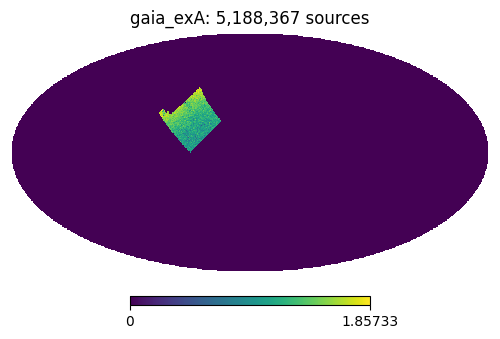

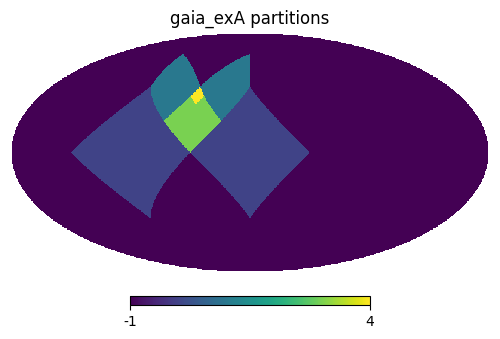

In [7]:
#visualize the sources and the partitioned structure
#c1 = hc.Catalog('sdss_real', location='/epyc/projects3/sam_hipscat/')
c1.visualize_sources()
c1.visualize_partitions()

In [8]:
# loading the catalog as a dask.dataframe
ddf = c1.load()

# verifying dtype
print(f'type of ddf: {type(ddf)}')

# total number of sources
print(len(ddf))

# the column names for the catalog
print([x for x in ddf.columns])

# dask.dataframe structure
ddf

type of ddf: <class 'dask.dataframe.core.DataFrame'>
5188367
['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pm', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'nu_eff_used_in_astrometry', 'pseudocolour', 'pseudocolour_error', 'ra_pseudocolour_corr', 'dec_pseudocolour_corr', 'parallax_pseudocolour_corr', 'pmra_pseudocolour_corr', 'pmdec_pseudocolour_corr', 'astrometric_matched_transits', 'visibility_periods_used', 'astrometr

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,Norder,Npix,Dir
npartitions=23,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,bool,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,bool,bool,int64,bool,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float6

In [9]:
#examples of leveraging the dask.dataframe API
columns = [
    'ra', 'dec', 'source_id', 'pmra', 'pmdec', 'parallax', 'radial_velocity'
]

#load your catalog as dask.dataframe
ddf = c1.load(columns=columns)

#assigning columns, then querying
x = ddf.assign(
    pm=lambda x: np.sqrt(x['pmra']**2 + x['pmdec']**2)
).query(
    'pm > 20.0 and radial_velocity > 0' 
)

#nothing executes until your perform .compute()
x.compute()

,ra,dec,source_id,pmra,pmdec,parallax,radial_velocity,pm
_ID,,,,,,,,
270260499273220096,44.753219,30.302375,135130189508722816,52.974700,-8.326439,3.000565,31.698118,53.625073
270268144315006976,44.843620,30.479148,135134072159139456,26.167949,-16.089877,3.496741,3.298522,30.718817
270269750632775680,44.982390,30.406517,135134862433124352,46.371700,33.466880,6.135957,9.709143,57.187119
270275166586535936,45.150948,30.538982,135137572556491648,71.271599,-14.824812,3.530566,31.508825,72.797087
270284628399489024,44.978538,30.606400,135142318496329856,23.233354,-9.737456,3.933044,4.284767,25.191403
...,...,...,...,...,...,...,...,...
299377074710249472,65.847626,25.281265,149688410656598400,41.025431,-53.739766,4.055768,4.959910,67.609530
299381833534013440,65.884316,25.333802,149690811540887168,47.043365,-30.848830,3.965665,45.555160,56.255919
299381919433359360,65.884587,25.334626,149690850198011392,47.023633,-30.439677,4.012601,48.209750,56.016033


## 3.) Spatial analysis of hipscats

Here we detail the 'out of the box' spatial methods that are optimized with HiPSCats:
* Cone Searches (pencil-beam)
* Catalog Cross-matches (nearest neighbors)

### Cone Searches
Find all sources at a radius (in degrees) from a position (RA,DEC: in decimal degrees)
* Visualize


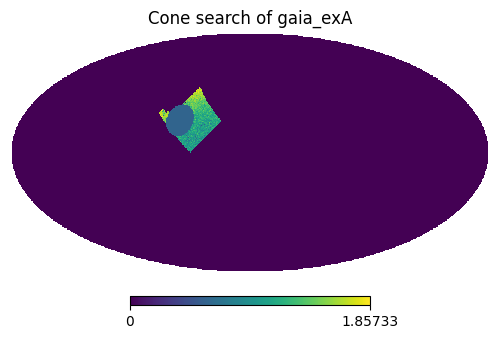

In [10]:
ra=55.0
dec=20.0
radius=10

c1.visualize_cone_search(
    ra, dec, radius
)

* perform Cone Search
    * returns a dask dataframe

In [11]:

x = c1.cone_search(
    ra=56, 
    dec=20,
    radius=10.0,
    columns=['ra', 'dec', 'source_id', 'pmra', 'pmdec']
).assign(
    pm=lambda x: np.sqrt(x['pmra']**2 + x['pmdec']**2)
)

x.compute()

,ra,dec,source_id,pmra,pmdec,_DIST,pm
_ID,,,,,,,
54043358737203200,47.365225,16.370170,31476582657234560,NaN,NaN,8.968321,NaN
57702584974049280,48.754265,12.851207,29423618354096256,1.734043,-3.491719,9.966132,3.898590
57702632218689536,48.739484,12.831290,29423480915138304,0.191955,2.054853,9.990516,2.063799
57702640808624128,48.762516,12.858461,29423622649681792,0.597311,-2.392302,9.955338,2.465743
57702864146923520,48.773234,12.866788,29423652713837696,1.368023,-3.486677,9.942114,3.745451
...,...,...,...,...,...,...,...
252195016422719488,55.609505,29.982536,120107489123048448,0.353011,-0.479003,9.988783,0.595030
252195020717686784,55.621408,29.989345,120107489123055744,6.237448,-3.691611,9.995212,7.248017
252195042192523264,55.612783,29.991994,120107493419086464,0.137075,-0.572065,9.998130,0.588258


### Cross Matching
Performing a nearest neighbors cross match of two hipscat catalogs
 * specify columns from each catalog to return
 * set the number of neighbors
 * set the distance threshold (degrees)
 * returns a dask.dataframe
 * visual aspect soon (intersection)


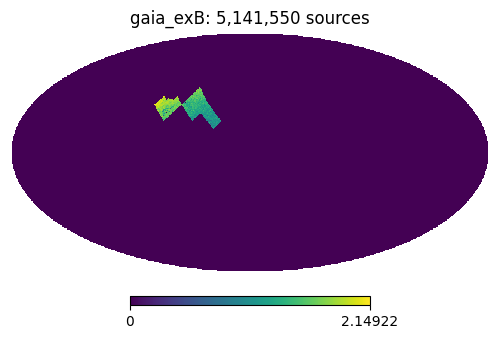

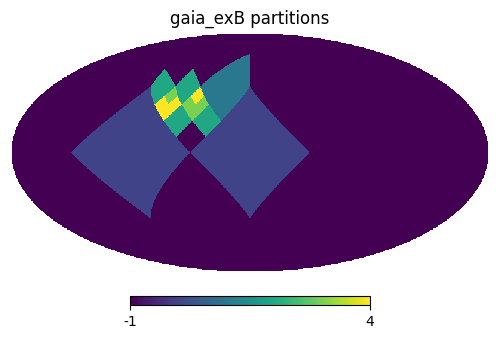

In [12]:
#load our second example
c2 = hc.Catalog('gaia_exB', location=HIPS_DIR)
c2.visualize_sources()
c2.visualize_partitions()


In [13]:
#performing catalog cross matching

#specifying columns to return from crossmatch+dtype
# requirement for dask.dataframe.map_partitions
c1_cols = ['pmra']
c2_cols = ['pmdec', 'radial_velocity']

#perform the crossmatch
result = c1.cross_match(
    c2, 
    c1_cols=c1_cols, 
    c2_cols=c2_cols, 
    n_neighbors=1,
    dthresh=0.1, #degrees
    evaluate_margins=True
).assign(
    pm=lambda x: np.sqrt(x['gaia_exA.pmra']**2 + x['gaia_exB.pmdec']**2)
).query(
    'pm > 20.0 and `gaia_exB.radial_velocity` > 0' #use backticks around prefixed column names
)

#execute the dask.dataframe result
result.compute()

,gaia_exA.pmra,gaia_exA.ra,gaia_exA.dec,gaia_exA.source_id,gaia_exB.pmdec,gaia_exB.radial_velocity,gaia_exB.ra,gaia_exB.dec,gaia_exB.source_id,hips_k,hips_pix,_DIST,pm
928,52.974700,44.753219,30.302375,135130189508722816,-8.326439,31.698118,44.753219,30.302375,135130189508722816,4,60,0.000000,53.625073
1096,26.167949,44.843620,30.479148,135134072159139456,-16.089877,3.298522,44.843620,30.479148,135134072159139456,4,60,0.000000,30.718817
1134,46.371700,44.982390,30.406517,135134862433124352,33.466880,9.709143,44.982390,30.406517,135134862433124352,4,60,0.000000,57.187119
1265,71.271599,45.150948,30.538982,135137572556491648,-14.824812,31.508825,45.150948,30.538982,135137572556491648,4,60,0.000000,72.797087
1505,23.233354,44.978538,30.606400,135142318496329856,-9.737456,4.284767,44.978538,30.606400,135142318496329856,4,60,0.000000,25.191403
...,...,...,...,...,...,...,...,...,...,...,...,...,...
370052,0.260616,66.973153,24.263124,149333332822666496,-21.331606,3.005037,67.046363,24.199783,146329540071246464,4,64,0.092027,21.333198
370053,2.246138,66.970482,24.270567,149333337119382528,-21.331606,3.005037,67.046363,24.199783,146329540071246464,4,64,0.098985,21.449535
370055,9.056699,66.977098,24.275865,149333367182407424,-21.331606,3.005037,67.046363,24.199783,146329540071246464,4,64,0.098881,23.174581
370056,7.976141,66.977693,24.275846,149333371479119872,-21.331606,3.005037,67.046363,24.199783,146329540071246464,4,64,0.098521,22.774025


In [14]:
client.close()